In [1]:
import os
import json
import numpy as np
import librosa
import pywt  # Áî®‰∫éËøûÁª≠Â∞èÊ≥¢ÂèòÊç¢ (CWT)
import cv2   # Áî®‰∫éÂõæÂÉèÂ§ÑÁêÜÂíå‰øùÂ≠ò
import matplotlib.pyplot as plt
# Â¶ÇÊûúÈúÄË¶ÅËøõË°åÊ®°ÂûãÊé®ÁêÜÂíåGrad-CAM
import torch
import torch.nn as nn
import torch.nn.functional as F

# ÈÖçÁΩÆË∑ØÂæÑÂíåÂèÇÊï∞
base_dir = "./Voice/KCL_Text_HC"  # Êï∞ÊçÆÈõÜÊ†πÁõÆÂΩïÔºåÈúÄË¶ÅÊ†πÊçÆÂÆûÈôÖË∑ØÂæÑ‰øÆÊîπ
output_suffix = "_Output"    # ËæìÂá∫Êñá‰ª∂Â§πÁöÑÂêéÁºÄ
target_sr = 16000            # ÈáçÈááÊ†∑ÁõÆÊ†áÈááÊ†∑Áéá

# ÈÅçÂéÜÊï∞ÊçÆÈõÜÁõÆÂΩïÔºåÊî∂ÈõÜÊâÄÊúâÈùûOutputÂ≠êÁõÆÂΩï‰∏ãÁöÑwavÊñá‰ª∂Ë∑ØÂæÑ
wav_files = []
for root, dirs, files in os.walk(base_dir):
    # Ë∑≥ËøáOutputÊñá‰ª∂Â§π
    if output_suffix.lower() in root.lower():
        continue
    for fname in files:
        if fname.lower().endswith(".wav"):
            full_path = os.path.join(root, fname)
            wav_files.append(full_path)

print(f"ÂÖ±ÊâæÂà∞ {len(wav_files)} ‰∏™Èü≥È¢ëÊñá‰ª∂ÂæÖÂ§ÑÁêÜ„ÄÇ")

# Á°Æ‰øùÊØè‰∏™ÂØπÂ∫îÁöÑ Output Êñá‰ª∂Â§πÂ≠òÂú®
for root, dirs, files in os.walk(base_dir):
    for d in dirs:
        if d.endswith(output_suffix):
            out_dir = os.path.join(root, d)
            os.makedirs(out_dir, exist_ok=True)


ÂÖ±ÊâæÂà∞ 527 ‰∏™Èü≥È¢ëÊñá‰ª∂ÂæÖÂ§ÑÁêÜ„ÄÇ


In [2]:
# ËæÖÂä©ÂáΩÊï∞ÔºöËÆ°ÁÆóÂπ∂ËøîÂõû CQT dB È¢ëË∞±Áü©ÈòµÂíåÈ¢ëÁéáËΩ¥
def compute_cqt_spectrogram(y, sr, bins_per_octave=84):
    # ‰ΩøÁî® librosa ËÆ°ÁÆóÂ∏∏Êï∞QÂèòÊç¢ (CQT)
    C = librosa.cqt(y, sr=sr, hop_length=512, fmin=librosa.note_to_hz('C1'),
                    n_bins=bins_per_octave, bins_per_octave=12)
    C_mag = np.abs(C)  # ÂèñÂπÖÂÄº
    # ËΩ¨Êç¢‰∏∫ÂØπÊï∞ÂàªÂ∫¶ (dB)
    C_db = librosa.amplitude_to_db(C_mag, ref=np.max, top_db=80)
    # Ëé∑ÂèñÈ¢ëÁéáËΩ¥ËåÉÂõ¥Ôºà‰ΩøÁî® librosa Êèê‰æõÁöÑÂ∑•ÂÖ∑Ôºâ
    freqs = librosa.cqt_frequencies(C_db.shape[0], fmin=librosa.note_to_hz('C1'), bins_per_octave=12)
    return C_db, freqs

# ËæÖÂä©ÂáΩÊï∞ÔºöËÆ°ÁÆóÂπ∂ËøîÂõû Scalogram (CWT) dB È¢ëË∞±Áü©ÈòµÂíåÈ¢ëÁéáËΩ¥
def compute_cwt_scalogram(y, sr, wavelet='morl', num_scales=128):
    # ÂÆö‰πâÂ∞∫Â∫¶Â∫èÂàóÔºà‰ªé1Âà∞num_scalesÔºâ
    scales = np.arange(1, num_scales + 1)
    # ËÆ°ÁÆóËøûÁª≠Â∞èÊ≥¢ÂèòÊç¢ (CWT)
    coefficients, frequencies = pywt.cwt(y, scales, wavelet, sampling_period=1.0/sr)
    # CWT ËøîÂõûÁöÑ coefficients shape: (num_scales, signal_length)
    # ÂèñÁªùÂØπÂÄº
    cwt_mag = np.abs(coefficients)
    # ËΩ¨Êç¢‰∏∫ÂØπÊï∞ÂàªÂ∫¶ (dB)ÔºåÂèÇËÄÉÊúÄÂ§ßÂÄº
    cwt_db = librosa.amplitude_to_db(cwt_mag, ref=np.max, top_db=80)
    # È¢ëÁéáËΩ¥Â∑≤Áî± PyWavelets ËøîÂõûÔºàÈôçÂ∫èÔºâÔºåÂ∞ÜÂÖ∂ÁøªËΩ¨‰∏∫ÂçáÂ∫è‰ª•ÂØπÂ∫îÁü©ÈòµË°åÈ°∫Â∫è
    freqs = frequencies[::-1]  # frequencies ‰∏é scales ‰∏Ä‰∏ÄÂØπÂ∫îÔºà‰ªéÈ´òÈ¢ëÂà∞‰ΩéÈ¢ëÔºâÔºåÁøªËΩ¨‰∏∫‰ªé‰ΩéÈ¢ëÂà∞È´òÈ¢ë
    cwt_db = cwt_db[::-1]      # Áõ∏Â∫îÂú∞ÁøªËΩ¨Á≥ªÊï∞Áü©ÈòµÔºå‰ΩøÂæó [0,0] ÂØπÂ∫îÊúÄ‰ΩéÈ¢ëÁéá
    return cwt_db, freqs

# ËæÖÂä©ÂáΩÊï∞ÔºöÂ∞ÜÈ¢ëË∞±dBÁü©ÈòµÊò†Â∞Ñ‰∏∫ÂΩ©Ëâ≤ÂõæÂÉèÂπ∂‰øùÂ≠ò
def save_spectrogram_image(db_matrix, cmap, save_path):
    """
    Â∞ÜÁªôÂÆöÁöÑdBÈ¢ëË∞±Áü©ÈòµÊò†Â∞Ñ‰∏∫0-255Âπ∂‰øùÂ≠ò‰∏∫ÂΩ©Ëâ≤PNGÂõæÂÉè„ÄÇ
    cmap ÂèÇÊï∞‰∏∫ OpenCV ÁöÑÈ¢úËâ≤Êò†Â∞ÑÔºå‰æãÂ¶Ç cv2.COLORMAP_VIRIDIS„ÄÇ
    """
    # Â∞ÜdBÂÄº‰ªé[-X, 0]ÂΩí‰∏ÄÂåñÂà∞[0, 255]
    db_min = db_matrix.min()
    db_max = db_matrix.max()
    norm_matrix = (db_matrix - db_min) / (db_max - db_min + 1e-6)  # [0, 1]
    img_gray = (norm_matrix * 255).astype(np.uint8)
    # Â∫îÁî®‰º™ÂΩ©Ëâ≤
    img_color = cv2.applyColorMap(img_gray, cmap)
    # Â∞ÜBGRÊ†ºÂºèËΩ¨Êç¢‰∏∫RGBÂÜç‰øùÂ≠ò
    img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    cv2.imwrite(save_path, img_rgb)


In [3]:
# ÈÄâÊã©È¢úËâ≤Êò†Â∞Ñ (OpenCV Â∏∏Èáè)ÔºåËøôÈáå‰ΩøÁî® VIRIDISÔºåÂèØÊ†πÊçÆÈúÄË¶ÅÊõ¥Êîπ‰∏∫ INFERNO Á≠â
cmap = cv2.COLORMAP_VIRIDIS

# Â§ÑÁêÜÊØè‰∏™Èü≥È¢ëÊñá‰ª∂
for wav_path in wav_files:
    # Âä†ËΩΩÈü≥È¢ëÂπ∂ÈáçÈááÊ†∑Âà∞ target_sr
    y, sr = librosa.load(wav_path, sr=target_sr)
    duration = len(y) / sr  # Èü≥È¢ëÊó∂ÈïøÔºàÁßíÔºâ

    # ÁîüÊàê CQT È¢ëË∞±Âíå Scalogram
    cqt_db, cqt_freqs = compute_cqt_spectrogram(y, sr)
    cwt_db, cwt_freqs = compute_cwt_scalogram(y, sr)

    # ÊûÑÂª∫ËæìÂá∫Êñá‰ª∂Ë∑ØÂæÑ
    # ËæìÂá∫ÁõÆÂΩïÔºöÁî®ÂΩìÂâçÈü≥È¢ëË∑ØÂæÑ‰∏≠ÊâæÂà∞ÁöÑÂØπÂ∫î *_Output ÁõÆÂΩï
    # ‰æãÂ¶Ç input: "China_HC/abc.wav" -> output_dir: "China_Output"
    dir_path, file_name = os.path.split(wav_path)
    # ÊâæÂà∞ÂêåÁ∫ßÁõÆÂΩï‰∏ãÁöÑ *Output ÁõÆÂΩï
    parent_dir = os.path.dirname(dir_path)
    base_folder = os.path.basename(dir_path)
    output_folder = base_folder.split(os.sep)[0] + output_suffix if not base_folder.endswith(output_suffix) else base_folder
    output_dir = os.path.join(parent_dir, output_folder)
    os.makedirs(output_dir, exist_ok=True)
    name_base, _ = os.path.splitext(file_name)
    # Á°Æ‰øùÊñá‰ª∂ÂêçÂîØ‰∏ÄÔºöÂèØ‰ª•Âä†‰∏äÁà∂Êñá‰ª∂Â§πÂêçÁß∞ÂâçÁºÄ
    output_prefix = name_base
    if base_folder not in output_folder:
        output_prefix = f"{base_folder}_{name_base}"

    cqt_img_path = os.path.join(output_dir, f"{output_prefix}_cqt.png")
    cwt_img_path = os.path.join(output_dir, f"{output_prefix}_cwt.png")
    json_path    = os.path.join(output_dir, f"{output_prefix}_spec.json")

    # ‰øùÂ≠òÈ¢ëË∞±ÂõæÂΩ©Ëâ≤ÂõæÂÉè
    save_spectrogram_image(cqt_db, cmap, cqt_img_path)
    save_spectrogram_image(cwt_db, cmap, cwt_img_path)

    # ÂáÜÂ§áÂÖÉÊï∞ÊçÆ JSONÔºàÊó∂Èó¥ËΩ¥ÂíåÈ¢ëÁéáËΩ¥ËåÉÂõ¥„ÄÅÂàÜËæ®ÁéáÁ≠âÔºâ
    data = {
        "audio_path": wav_path,
        "duration_sec": duration,
        "sr": sr,
        "cqt": {
            "freq_min": float(cqt_freqs.min()) if cqt_freqs.size > 0 else 0.0,
            "freq_max": float(cqt_freqs.max()) if cqt_freqs.size > 0 else float(sr/2),
            "n_bins": int(cqt_db.shape[0]),
            "time_bins": int(cqt_db.shape[1]),
            "time_resolution_sec": 512 / sr  # hop_length / sr
        },
        "cwt": {
            "freq_min": float(cwt_freqs.min()) if cwt_freqs.size > 0 else 0.0,
            "freq_max": float(cwt_freqs.max()) if cwt_freqs.size > 0 else float(sr/2),
            "scales": int(cwt_db.shape[0]),
            "time_samples": int(cwt_db.shape[1]),
            "time_resolution_sec": 1.0/sr   # CWTËæìÂá∫Êó∂Èó¥Ê≠•Ëøë‰ºº‰∏∫ÈááÊ†∑ÁÇπÈó¥Èöî
        }
    }
    # ‰øùÂ≠ò JSON ‰ø°ÊÅØ
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

    print(f"Processed {wav_path} -> {cqt_img_path}, {cwt_img_path}")


Processed ./Voice/KCL_Text_HC/ID25_hc_0_0_0_chunk132.wav -> ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk132_cqt.png, ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk132_cwt.png
Processed ./Voice/KCL_Text_HC/ID25_hc_0_0_0_chunk126.wav -> ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk126_cqt.png, ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk126_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk0.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk0_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk0_cwt.png
Processed ./Voice/KCL_Text_HC/ID28_hc_0_0_0_chunk138.wav -> ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk138_cqt.png, ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk138_cwt.png
Processed ./Voice/KCL_Text_HC/ID11_hc_0_0_0_chunk6.wav -> ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk6_cqt.png, ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk6_cwt.png
Processed ./Voice/KCL_Text_HC/ID10_hc_0_0_0_chunk102.wav -> ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk102_cqt.png, ./Voice/

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk12.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk12_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk12_cwt.png
Processed ./Voice/KCL_Text_HC/ID10_hc_0_0_0_chunk6.wav -> ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk6_cqt.png, ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk6_cwt.png
Processed ./Voice/KCL_Text_HC/ID00_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk54_cwt.png
Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0_chunk168.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk168_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk168_cwt.png
Processed ./Voice/KCL_Text_HC/ID36_hc_0_0_0_chunk36.wav -> ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk36_cqt.png, ./Voice/KCL_Text_HC_Output/ID36_hc_0_

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID14_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID14_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID14_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID05_hc_0_0_0_chunk96.wav -> ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk96_cqt.png, ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk96_cwt.png
Processed ./Voice/KCL_Text_HC/ID12_hc_0_0_0_chunk78.wav -> ./Voice/KCL_Text_HC_Output/ID12_hc_0_0_0_chunk78_cqt.png, ./Voice/KCL_Text_HC_Output/ID12_hc_0_0_0_chunk78_cwt.png
Processed ./Voice/KCL_Text_HC/ID36_hc_0_0_0_chunk138.wav -> ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk138_cqt.png, ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk138_cwt.png
Processed ./Voice/KCL_Text_HC/ID03_hc_0_0_0_chunk120.wav -> ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk120_cqt.png, ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk120_cwt.png
Processed ./Voice/KCL_Text_HC/ID03_hc_0_0_0_chunk108.wav -> ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk108_cqt.png, ./Voice/KCL_Text_HC_Output/ID

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID25_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0_chunk48.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk48_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk48_cwt.png
Processed ./Voice/KCL_Text_HC/ID15_hc_0_0_0_chunk108.wav -> ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk108_cqt.png, ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk108_cwt.png
Processed ./Voice/KCL_Text_HC/ID15_hc_0_0_0_chunk120.wav -> ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk120_cqt.png, ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk120_cwt.png


libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID25_hc_0_0_0_chunk78.wav -> ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk78_cqt.png, ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk78_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk126.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk126_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk126_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk132.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk132_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk132_cwt.png
Processed ./Voice/KCL_Text_HC/ID21_hc_0_0_0_chunk18.wav -> ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_chunk18_cqt.png, ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_chunk18_cwt.png
Processed ./Voice/KCL_Text_HC/ID21_hc_0_0_0_chunk24.wav -> ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_chunk24_cqt.png, ./Voice/KCL_Text_HC_Output/ID21

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID12_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID12_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID12_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID00_hc_0_0_0_chunk90.wav -> ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk90_cqt.png, ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk90_cwt.png
Processed ./Voice/KCL_Text_HC/ID28_hc_0_0_0_chunk12.wav -> ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk12_cqt.png, ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk12_cwt.png


libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID15_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0_chunk0.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk0_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk0_cwt.png
Processed ./Voice/KCL_Text_HC/ID11_hc_0_0_0_chunk72.wav -> ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk72_cqt.png, ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk72_cwt.png
Processed ./Voice/KCL_Text_HC/ID11_hc_0_0_0_chunk66.wav -> ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk66_cqt.png, ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk66_cwt.png
Processed ./Voice/KCL_Text_HC/ID25_hc_0_0_0_chunk96.wav -> ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk96_cqt.png, ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk96_cwt.png
Processed ./Voice/KCL_Text_HC/ID25_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID00_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0_chunk0.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk0_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk0_cwt.png
Processed ./Voice/KCL_Text_HC/ID12_hc_0_0_0_chunk42.wav -> ./Voice/KCL_Text_HC_Output/ID12_hc_0_0_0_chunk42_cqt.png, ./Voice/KCL_Text_HC_Output/ID12_hc_0_0_0_chunk42_cwt.png
Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0_chunk108.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk108_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk108_cwt.png
Processed ./Voice/KCL_Text_HC/ID05_hc_0_0_0_chunk90.wav -> ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk90_cqt.png, ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk90_cwt.png
Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0_chunk120.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk120_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID36_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID25_hc_0_0_0_chunk42.wav -> ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk42_cqt.png, ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk42_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk108.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk108_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk108_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk120.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk120_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk120_cwt.png
Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0_chunk186.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk186_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk186_cwt.png
Processed ./Voice/KCL_Text_HC/ID21_hc_0_0_0_chunk36.wav -> ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_chunk36_cqt.png, ./Voice/KCL_Text_HC_Output/I

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk132.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk132_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk132_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk138.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk138_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk138_cwt.png
Processed ./Voice/KCL_Text_HC/ID05_hc_0_0_0_chunk78.wav -> ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk78_cqt.png, ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk78_cwt.png
Processed ./Voice/KCL_Text_HC/ID26_hc_0_0_0_chunk66.wav -> ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk66_cqt.png, ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk66_cwt.png
Processed ./Voice/KCL_Text_HC/ID12_hc_0_0_0_chunk96.wav -> ./Voice/KCL_Text_HC_Output/ID12_hc_0_0_0_chunk96_cqt.png, ./Voice/KCL_Text_HC_Output/ID12

Processed ./Voice/KCL_Text_HC/ID15_hc_0_0_0_chunk156.wav -> ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk156_cqt.png, ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk156_cwt.png
Processed ./Voice/KCL_Text_HC/ID15_hc_0_0_0_chunk48.wav -> ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk48_cqt.png, ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk48_cwt.png
Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0_chunk108.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk108_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk108_cwt.png
Processed ./Voice/KCL_Text_HC/ID19_hc_0_0_0_chunk6.wav -> ./Voice/KCL_Text_HC_Output/ID19_hc_0_0_0_chunk6_cqt.png, ./Voice/KCL_Text_HC_Output/ID19_hc_0_0_0_chunk6_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk66.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk66_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk66_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk72.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk72_cqt.png, ./Voice/KC

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID28_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_cwt.png


libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_cwt.png
Processed ./Voice/KCL_Text_HC/ID26_hc_0_0_0_chunk138.wav -> ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk138_cqt.png, ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk138_cwt.png
Processed ./Voice/KCL_Text_HC/ID26_hc_0_0_0_chunk12.wav -> ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk12_cqt.png, ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk12_cwt.png
Processed ./Voice/KCL_Text_HC/ID05_hc_0_0_0_chunk18.wav -> ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk18_cqt.png, ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk18_cwt.png
Processed ./Voice/KCL_Text_HC/ID05_hc_0_0_0_chunk30.wav -> ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk30_cqt.png, ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk30_cwt.png
Processed ./Voice/KCL_Text_HC/ID05_hc_0_0_0_chunk24.wav -> ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk24_cqt.png, ./Voice/KCL_Text_HC_Output/ID05_hc

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID19_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID19_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID19_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID21_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_chunk54_cwt.png
Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0_chunk114.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk114_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk114_cwt.png
Processed ./Voice/KCL_Text_HC/ID28_hc_0_0_0_chunk72.wav -> ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk72_cqt.png, ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk72_cwt.png
Processed ./Voice/KCL_Text_HC/ID28_hc_0_0_0_chunk66.wav -> ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk66_cqt.png, ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk66_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk0.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk0_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0

/Users/beibeiliu/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=256 is too large for input signal of length=244
  warnings.warn(


Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk192.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk192_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk192_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk186.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk186_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk186_cwt.png
Processed ./Voice/KCL_Text_HC/ID10_hc_0_0_0_chunk42.wav -> ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk42_cqt.png, ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk42_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk174.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk174_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk174_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk156.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk156_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk156_cwt.png
Processed ./Voice/KCL_Text_HC/ID35_hc_0_0_0_chunk6.wav -> ./Voice/KCL_Text_HC_Output/ID35_hc_0_0_0_chunk6_cqt.png, ./V

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID28_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk54_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk84.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk84_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk84_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk90.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk90_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk90_cwt.png
Processed ./Voice/KCL_Text_HC/ID15_hc_0_0_0_chunk96.wav -> ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk96_cqt.png, ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk96_cwt.png
Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0_chunk126.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk126_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_

Processed ./Voice/KCL_Text_HC/ID36_hc_0_0_0_chunk156.wav -> ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk156_cqt.png, ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk156_cwt.png
Processed ./Voice/KCL_Text_HC/ID10_hc_0_0_0_chunk90.wav -> ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk90_cqt.png, ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk90_cwt.png
Processed ./Voice/KCL_Text_HC/ID10_hc_0_0_0_chunk84.wav -> ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk84_cqt.png, ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk84_cwt.png


libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk66.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk66_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk66_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk78.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk78_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk78_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk72.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk72_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk72_cwt.png
Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk54_cwt.png
Processed ./Voice/KCL_Text_HC/ID28_hc_0_0_0_chunk90.wav -> ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk90_cqt.png, ./Voice/KCL_Text_HC_Output/ID28_hc_0_

/Users/beibeiliu/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=256 is too large for input signal of length=174
  warnings.warn(
/Users/beibeiliu/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=256 is too large for input signal of length=87
  warnings.warn(


Processed ./Voice/KCL_Text_HC/ID36_hc_0_0_0_chunk0.wav -> ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk0_cqt.png, ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk0_cwt.png
Processed ./Voice/KCL_Text_HC/ID36_hc_0_0_0_chunk126.wav -> ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk126_cqt.png, ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk126_cwt.png
Processed ./Voice/KCL_Text_HC/ID36_hc_0_0_0_chunk132.wav -> ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk132_cqt.png, ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk132_cwt.png
Processed ./Voice/KCL_Text_HC/ID03_hc_0_0_0_chunk102.wav -> ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk102_cqt.png, ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk102_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk36.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk36_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk36_cwt.png


libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID10_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID00_hc_0_0_0_chunk144.wav -> ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk144_cqt.png, ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk144_cwt.png
Processed ./Voice/KCL_Text_HC/ID00_hc_0_0_0_chunk150.wav -> ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk150_cqt.png, ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk150_cwt.png
Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0_chunk174.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk174_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk174_cwt.png
Processed ./Voice/KCL_Text_HC/ID00_hc_0_0_0_chunk48.wav -> ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk48_cqt.png, ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk48_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk0.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk0_cqt.png, ./Voice/KCL_Text_HC_Output/ID2

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID05_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk138.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk138_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk138_cwt.png
Processed ./Voice/KCL_Text_HC/ID11_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk54_cwt.png
Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0_chunk90.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk90_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk90_cwt.png
Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0_chunk84.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk84_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk84_cwt.png
Processed ./Voice/KCL_Text_HC/ID21_hc_0_0_0_chunk12.wav -> ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_chunk12_cqt.png, ./Voice/KCL_Text_HC_Output/ID21_hc

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID26_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk24.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk24_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk24_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk30.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk30_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk30_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk18.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk18_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk18_cwt.png
Processed ./Voice/KCL_Text_HC/ID15_hc_0_0_0_chunk36.wav -> ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk36_cqt.png, ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk36_cwt.png
Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID21_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0_chunk18.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk18_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk18_cwt.png
Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0_chunk30.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk30_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk30_cwt.png
Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0_chunk24.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk24_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk24_cwt.png
Processed ./Voice/KCL_Text_HC/ID03_hc_0_0_0_chunk90.wav -> ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk90_cqt.png, ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk90_cwt.png
Processed ./Voice/KCL_Text_HC/ID03_hc_0_0_0_chunk84.wav -> ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk84_cqt.png, ./Voice/KCL_Text_HC_Output/ID03_hc_0_

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID03_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk12.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk12_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk12_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk18.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk18_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk18_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk30.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk30_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk30_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk24.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk24_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk24_cwt.png
Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_0_

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID11_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk102.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk102_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk102_cwt.png
Processed ./Voice/KCL_Text_HC/ID26_hc_0_0_0_chunk0.wav -> ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk0_cqt.png, ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk0_cwt.png
Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0_chunk96.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk96_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk96_cwt.png
Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0_chunk198.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk198_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk198_cwt.png
Processed ./Voice/KCL_Text_HC/ID03_hc_0_0_0_chunk42.wav -> ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk42_cqt.png, ./Voice/KCL_Text_HC_Output/ID03_hc

OSError: [Errno 28] No space left on device: './Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk126_spec.json'

In [6]:
# ÂàõÂª∫ËæìÂá∫ÁõÆÂΩïÁî®‰∫é‰øùÂ≠òÂèØËßÜÂåñÂõæË°®
os.makedirs("figures", exist_ok=True)

import librosa.display  # librosa ÁöÑÊòæÁ§∫Ê®°ÂùóÁî®‰∫éÁªòÂà∂È¢ëË∞±

def compare_voice_features(file_pd, file_hc, sr=16000):
    # Âä†ËΩΩ‰∏§‰∏™Èü≥È¢ëÊñá‰ª∂ÔºàÂÅáÂÆöfile_pd‰∏∫PDÊÇ£ËÄÖËØ≠Èü≥Ôºåfile_hc‰∏∫ÂÅ•Â∫∑ÂØπÁÖßËØ≠Èü≥Ôºâ
    y_pd, _ = librosa.load(file_pd, sr=sr)
    y_hc, _ = librosa.load(file_hc, sr=sr)
    # ËÆ°ÁÆóÊó∂Èïø
    dur_pd = len(y_pd) / sr
    dur_hc = len(y_hc) / sr

    # ËÆ°ÁÆóMelÈ¢ëË∞±Âõæ (ËΩ¨Êç¢‰∏∫ÂØπÊï∞ÂπÖÂ∫¶)
    mel_pd = librosa.feature.melspectrogram(y_pd, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_pd_db = librosa.power_to_db(mel_pd, ref=np.max)
    mel_hc = librosa.feature.melspectrogram(y_hc, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_hc_db = librosa.power_to_db(mel_hc, ref=np.max)

    # ÊèêÂèñÂü∫È¢ë (F0) ËΩÆÂªìÔºå‰ΩøÁî® librosa.pyin ÊñπÊ≥ï
    f0_pd, voiced_flag_pd, voiced_prob_pd = librosa.pyin(y_pd, sr=sr, frame_length=2048, hop_length=512, fmin=50, fmax=500)
    f0_hc, voiced_flag_hc, voiced_prob_hc = librosa.pyin(y_hc, sr=sr, frame_length=2048, hop_length=512, fmin=50, fmax=500)
    # Áî® NaN Ë°®Á§∫Êó†Â£∞ÊÆµÁöÑÂü∫È¢ëË°•ÂÖÖ‰∏∫ 0Ôºå‰æø‰∫éÁªòÂõæ
    f0_pd_plot = np.where(np.isnan(f0_pd), 0, f0_pd)
    f0_hc_plot = np.where(np.isnan(f0_hc), 0, f0_hc)

    # ËÆ°ÁÆóÁü≠Êó∂ËÉΩÈáè (ÂùáÊñπÊ†π) Â∫èÂàó
    rms_pd = librosa.feature.rms(y=y_pd, frame_length=2048, hop_length=512)[0]
    rms_hc = librosa.feature.rms(y=y_hc, frame_length=2048, hop_length=512)[0]

    # Êó∂Èó¥ËΩ¥Ôºà‰∏éÂ∏ßÂØπÂ∫îÔºâÔºåÂçï‰ΩçÁßí
    frames_pd = np.arange(len(f0_pd_plot))
    t_pd = frames_pd * (512 / sr)
    frames_hc = np.arange(len(f0_hc_plot))
    t_hc = frames_hc * (512 / sr)

    # ÂàõÂª∫ÂõæÂΩ¢Á™óÂè£Ôºå2Ë°å2ÂàóÂ∏ÉÂ±Ä
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    # ÁªòÂà∂ PD ÁöÑ Mel È¢ëË∞±
    librosa.display.specshow(mel_pd_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel',
                             cmap='magma', ax=axes[0, 0])
    axes[0, 0].set_title("PD Mel Spectrogram")
    # ÁªòÂà∂ HC ÁöÑ Mel È¢ëË∞±
    librosa.display.specshow(mel_hc_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel',
                             cmap='magma', ax=axes[0, 1])
    axes[0, 1].set_title("HC Mel Spectrogram")
    # ÁªòÂà∂Âü∫È¢ëËΩÆÂªì (PD vs HC)
    axes[1, 0].plot(t_pd, f0_pd_plot, label="PD Pitch (F0)", color='blue')
    axes[1, 0].plot(t_hc, f0_hc_plot, label="HC Pitch (F0)", color='orange')
    axes[1, 0].set_xlabel("Time (s)")
    axes[1, 0].set_ylabel("Fundamental Frequency (Hz)")
    axes[1, 0].legend()
    axes[1, 0].set_title("Pitch Contour Comparison")
    # ÁªòÂà∂ËÉΩÈáèËΩ®Ëøπ (PD vs HC)
    axes[1, 1].plot(t_pd, rms_pd, label="PD Energy", color='blue')
    axes[1, 1].plot(t_hc, rms_hc, label="HC Energy", color='orange')
    axes[1, 1].set_xlabel("Time (s)")
    axes[1, 1].set_ylabel("Energy (RMS)")
    axes[1, 1].legend()
    axes[1, 1].set_title("Energy Trajectory Comparison")

    plt.tight_layout()
    # ‰øùÂ≠òÂõæÂÉè
    output_fig = os.path.join("figures", "pitch_energy_mel_comparison.png")
    plt.savefig(output_fig)
    plt.close(fig)
    print(f"Saved comparison figure: {output_fig}")

# Á§∫‰æãË∞ÉÁî®ÔºöÈÄâÂèñGermanÊï∞ÊçÆÈõÜ‰∏≠ÁöÑÁ¨¨‰∏Ä‰∏™PDÂíåHCÈü≥È¢ëËøõË°åÂØπÊØîÂèØËßÜÂåñ
# Ê≥®ÊÑèÔºöËØ∑Â∞Ü‰∏ãÈù¢ÁöÑÊñá‰ª∂Ë∑ØÂæÑÊõøÊç¢‰∏∫ÂÆûÈôÖÂ≠òÂú®ÁöÑÈü≥È¢ëÊ†∑Êú¨Ë∑ØÂæÑ
example_pd = "./German_PD/001.wav"
example_hc = "./German_HC/001.wav"
if os.path.isfile(example_pd) and os.path.isfile(example_hc):
    compare_voice_features(example_pd, example_hc)


/usr/local/lib/python3.11/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Grad-CAM saved: figures/gradcam_activation.png


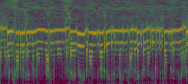

In [9]:
def generate_gradcam(model, input_image_path, target_layer_name, target_class_idx, output_path):
    """
    ÂØπÁªôÂÆöÊ®°ÂûãÂíåËæìÂÖ•ÂõæÂÉèËÆ°ÁÆóÊåáÂÆöÂ±ÇÁöÑGrad-CAMÔºåÂπ∂Â∞ÜÁÉ≠ÂäõÂõæÂè†Âä†Âú®ÂéüÂõæ‰∏ä‰øùÂ≠ò„ÄÇ
    - model: Â∑≤Âä†ËΩΩÁöÑ PyTorch Ê®°Âûã (eval Ê®°Âºè)
    - input_image_path: Ë¶ÅÂàÜÊûêÁöÑËæìÂÖ•ÂõæÂÉèË∑ØÂæÑÔºàÈ¢ëË∞±ÂõæPNGÔºâ
    - target_layer_name: Ê®°Âûã‰∏≠ÁõÆÊ†áÂç∑ÁßØÂ±ÇÁöÑÂêçÁß∞ (Â≠óÁ¨¶‰∏≤)
    - target_class_idx: ÊÑüÂÖ¥Ë∂£ÁöÑÁ±ªÂà´Á¥¢ÂºïÔºà‰æãÂ¶Ç PD Á±ªÂà´ÁöÑÁ¥¢ÂºïÔºâ
    - output_path: ËæìÂá∫Âè†Âä†ÂõæÂÉèÁöÑ‰øùÂ≠òË∑ØÂæÑ
    """
    # Á°Æ‰øùÊ®°ÂûãÂú®ËØÑ‰º∞Ê®°Âºè
    model.eval()

    # ËØªÂèñÂõæÂÉèÂπ∂ËΩ¨Êç¢‰∏∫Âº†Èáè
    img = cv2.imread(input_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # ËΩ¨‰∏∫RGB
    # ËΩ¨Êç¢‰∏∫tensorÂπ∂ÂΩí‰∏ÄÂåñÂà∞[0,1]ÔºàÂÅáÂÆöÊ®°ÂûãÊúüÊúõ0-1ÊàñÂèØËøõ‰∏ÄÊ≠•Ê†áÂáÜÂåñÔºåÂ¶ÇÈúÄË¶ÅÂèØ‰ª•ÂáèÂùáÂÄºÈô§ÊñπÂ∑ÆÔºâ
    img_tensor = torch.from_numpy(img).float().permute(2, 0, 1).unsqueeze(0) / 255.0

    # Á°ÆÂÆöÁõÆÊ†áÂ±Ç
    target_layer = dict(model.named_modules()).get(target_layer_name, None)
    if target_layer is None:
        raise ValueError(f"Layer {target_layer_name} not found in model.")
    # Áî®‰∫éÂ≠òÂÇ®ÂâçÂêëÊøÄÊ¥ªÂíåÊ¢ØÂ∫¶
    activation = {}
    gradient = {}

    # ÂÆö‰πâÂâçÂêëÈí©Â≠êÔºöËé∑ÂèñÂ±ÇËæìÂá∫
    def forward_hook(module, inp, out):
        activation[target_layer_name] = out.detach()

    # ÂÆö‰πâÂèçÂêëÈí©Â≠êÔºöËé∑ÂèñÂ±ÇÊ¢ØÂ∫¶
    def backward_hook(module, grad_in, grad_out):
        gradient[target_layer_name] = grad_out[0].detach()

    # Ê≥®ÂÜåÈí©Â≠ê
    hook_handle_forward = target_layer.register_forward_hook(forward_hook)
    hook_handle_backward = target_layer.register_backward_hook(backward_hook)

    # ÂâçÂêë‰º†Êí≠Ëé∑ÂèñËæìÂá∫
    output = model(img_tensor)
    if isinstance(output, (list, tuple)):
        output = output[0]  # Â¶ÇÊûúÊ®°ÂûãËæìÂá∫ÊòØtupleÔºåÂèñÁ¨¨‰∏Ä‰∏™
    # ÂèñÁõÆÊ†áÁ±ªÂà´ÁöÑÂàÜÊï∞
    target_score = output[0, target_class_idx]

    # Ê∏ÖÈô§ËøáÂæÄÊ¢ØÂ∫¶Âπ∂ÂèçÂêë‰º†Êí≠ÁõÆÊ†áÂàÜÊï∞
    model.zero_grad()
    target_score.backward()

    # Ëé∑Âèñ‰øùÂ≠òÁöÑÊøÄÊ¥ªÂõæÂíåÊ¢ØÂ∫¶
    act = activation[target_layer_name]  # shape: [1, C, H, W]
    grad = gradient[target_layer_name]   # shape: [1, C, H, W]
    # Èí©Â≠êÁî®ÂÆåÂ∞±ÁßªÈô§
    hook_handle_forward.remove()
    hook_handle_backward.remove()

    # ËÆ°ÁÆóÊØè‰∏™ÈÄöÈÅìÁöÑÊùÉÈáç: ÂØπÊ¢ØÂ∫¶ÁöÑÂÆΩÈ´òÂπ≥Âùá
    weights = grad.mean(dim=(2, 3), keepdim=True)  # shape: [1, C, 1, 1]
    # ÊåâÈÄöÈÅìÂä†ÊùÉÊ±ÇÂíåÊøÄÊ¥ªÂõæ
    cam = (weights * act).sum(dim=1, keepdim=True)  # shape: [1, 1, H, W]
    cam = F.relu(cam)  # ÈÄöËøáReLUÂéªÈô§Ë¥üÂÄº
    cam = cam.squeeze().cpu().numpy()

    # Â∞ÜcamÁÉ≠ÂäõÂõæË∞ÉÊï¥Âà∞‰∏éÂéüÂßãÂõæÂÉèÂ§ßÂ∞èÁõ∏Âêå
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
    # ÂΩí‰∏ÄÂåñÂà∞0-255
    cam_resized = cam_resized - cam_resized.min()
    cam_resized = cam_resized / (cam_resized.max() + 1e-8)
    cam_uint8 = (cam_resized * 255).astype(np.uint8)
    # Â∞ÜÁÉ≠ÂäõÂõæËΩ¨‰∏∫È¢úËâ≤Âè†Âä†
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    # Â∞ÜÁÉ≠ÂäõÂõæ‰∏éÂéüÂõæÊåâ‰∏ÄÂÆöÈÄèÊòéÂ∫¶Âè†Âä†
    overlay = (0.6 * img + 0.4 * heatmap).astype(np.uint8)
    cv2.imwrite(output_path, overlay)
    print(f"Grad-CAM saved: {output_path}")

# ÂÅáËÆæÂ∑≤ÁªèÊúâËÆ≠ÁªÉÂ•ΩÁöÑÊ®°Âûã `model`Ôºà‰∫åÂàÜÁ±ªÊ®°Âûã: 0=HC, 1=PDÔºâÔºåÂä†ËΩΩÊ®°ÂûãÊùÉÈáç
# ËøôÈáåÊàë‰ª¨ÊûÑÂª∫‰∏Ä‰∏™ÁÆÄÂåñÁöÑÁ§∫‰æãÊ®°ÂûãÁªìÊûÑÂπ∂ÊâãÂä®Âä†ËΩΩÔºàÂÆûÈôÖ‰ΩøÁî®Êó∂ÔºåËØ∑ÊõøÊç¢‰∏∫Ëá™Â∑±ÁöÑÊ®°ÂûãÊû∂ÊûÑÂíåÊùÉÈáçË∑ØÂæÑÔºâ
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.fc = nn.Linear(32, num_classes)  # ÂÅáËÆæÁªèËøáÊ±†ÂåñÂêéÈÄöÈÅìÊï∞ÊòØ 32
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # ÂÖ®Â±ÄÂπ≥ÂùáÊ±†Âåñ
        x = F.adaptive_avg_pool2d(x, 1).reshape(x.size(0), -1)
        x = self.fc(x)
        return x

# Âä†ËΩΩÊ®°ÂûãÔºàÂú®ÂÆûÈôÖÊÉÖÂÜµ‰∏≠ÔºåÁî®ÂÆûÈôÖËÆ≠ÁªÉÁöÑÊ®°ÂûãÂíåÂèÇÊï∞Ôºâ
# model = torch.load("path/to/trained_model.pth")
model = SimpleCNN(num_classes=2)
model.eval()

# Á§∫‰æãË∞ÉÁî® Grad-CAMÔºöÈÄâÂèñ‰πãÂâçÁîüÊàêÁöÑÊüêÂº†È¢ëË∞±Âõæ (Â¶Ç CQT Âõæ) ÂÅöÂàÜÊûê
example_spec_img = cqt_img_path  # ËøôÈáå‰ΩøÁî®ÊúÄÂêéÂ§ÑÁêÜÁöÑÈü≥È¢ëCQTÂõæ‰Ωú‰∏∫Á§∫‰æã
if os.path.isfile(example_spec_img):
    # target_layer_name Ê†πÊçÆÊ®°ÂûãËÄåÂÆöÔºåÊ≠§Â§Ñ‰ª•Á§∫‰æãÊ®°ÂûãÁöÑ 'conv2' ‰∏∫ÁõÆÊ†áÂ±Ç
    generate_gradcam(model, example_spec_img, target_layer_name='conv2',
                     target_class_idx=1,  # 1‰ª£Ë°®PDÁ±ªÔºàÂÅáÂÆöÔºâ
                     output_path="figures/gradcam_activation.png")
from IPython.display import Image, display
display(Image(filename="figures/gradcam_activation.png"))


**‚ÄúSpectro¬†Ablation¬†Experiments‚Äù**

| ‰ΩçÁΩÆ | ÂÖ≥ÈîÆÊîπÂä® | ‰ΩúÁî® |
|------|----------|------|
| **`ExperimentConfig`‚ÄØÊï∞ÊçÆÁ±ª** | Áªü‰∏ÄÁÆ°ÁêÜÂÆûÈ™åÂêç„ÄÅÊòØÂê¶‰ΩøÁî®Â±ÄÈÉ®‚ÄëÂÖ®Â±ÄÂ¢ûÂº∫„ÄÅÈ¢ëË∞±Ê®°ÂºèÔºàmulti / constantq / scalogramÔºâ„ÄÅÊòØÂê¶ÂêØÁî®Âõ†ÊûúÊ≥®ÊÑèÂäõ | ËÆ©ÊØè‰∏™Ê∂àËûçÂú∫ÊôØ‰∏ÄË°åÂ∞±ËÉΩÂÆö‰πâ |
| **`SpectrogramDataset`** | Êñ∞Â¢û¬†`spec_mode`¬†ËøáÊª§ÔºåÂçïÈ¢ëË∞±/Â§öÈ¢ëË∞±ËΩªÊùæÂàáÊç¢ | Áî®‰∫éÊØîËæÉÂçï‰∏ÄÈ¢ëË∞± vs Â§öÈ¢ëË∞± |
| **`GlobalLocalTransform`** | Âä† `enable_aug` ÂºÄÂÖ≥ÔºõÂÖ≥Èó≠Âêé‰ªÖÂÅöË£ÅÂâ™+Áº©Êîæ | Áî®‰∫éÊØîËæÉÊúâ/Êó†Â±ÄÈÉ®‚ÄëÂÖ®Â±ÄÂ¢ûÂº∫ |
| **`CausalSpectroNet`** | Âä† `use_causal_attention`ÔºåÂÖ≥Èó≠ÂêéÈÄÄÂåñ‰∏∫ GAP | Áî®‰∫éÈ™åËØÅÂõ†ÊûúÊú∫Âà∂Ë¥°ÁåÆ |
| **ÂÆûÈ™åÂæ™ÁéØ** | `run_experiment(cfg, seeds)`¬†‚Üí¬†ËøîÂõûÂ§öÊ¨°Áã¨Á´ã run ÁöÑÊµãËØïÈõÜÊåáÊ†á | Ëá™Âä®ÁÆóÂùáÂÄº‚ÄØ¬±‚ÄØstd |
| **ÁªüËÆ°Ê£ÄÈ™å** | ‰∏é baseline ÂÅö¬†Welch‚ÄØt‚ÄëtestÔºõËã•¬†*p*¬†<¬†0.05‚ÄØËá™Âä®ÊâìÂç∞¬†‚Äú‚òÖ‚Äù | ÁªìÊûúÊõ¥ÂÖ∑ËØ¥ÊúçÂäõ |
| **ÁªìÊûúËæìÂá∫** | ‚ë†¬†ÁªàÁ´ØË°®Ê†ºÔºàÂùáÂÄº¬±stdÔºåp ÂÄºÔºâ<br>‚ë°¬†Ëá™Âä®‰øùÂ≠ò‚ÄØ`ablation_results.csv`<br>‚ë¢¬†ÂèØÈÄâÊù°ÂΩ¢Âõæ `results_barplot.png` | ËÆ∫ÊñáÁõ¥Êé•Êà™Âõæ / ÂºïÁî® |


> ‰ª£Á†Å‰ºö‰æùÊ¨°ÊâßË°åÔºö  
> 1. **Baseline**ÔºàÂÖ®Á≠ñÁï•ÂêØÁî®Ôºâ  
> 2. ÂÖ≥Èó≠Â±ÄÈÉ®‚ÄëÂÖ®Â±ÄÂ¢ûÂº∫  
> 3. ÂçïÈ¢ëË∞±¬†Constant‚ÄëQ  
> 4. ÂçïÈ¢ëË∞±¬†Scalogram  
> 5. ÂÖ≥Èó≠Âõ†ÊûúÊ≥®ÊÑèÂäõ  
> Âπ∂Ëá™Âä®ÁîüÊàêÂØπÊØîË°®‰∏éÊòæËëóÊÄßÊ†áËÆ∞„ÄÇ


In [3]:
import os
import shutil
import re
from pathlib import Path

# Âü∫Êú¨Ë∑ØÂæÑ
root_dir = "Voice"
output_dir = os.path.join(root_dir, "Renamed_Files")
os.makedirs(output_dir, exist_ok=True)

# ‰∏≠ÊñáÂ≠óÁ¨¶Ê£ÄÊµã
def contains_chinese(text):
    return any('\u4e00' <= ch <= '\u9fff' for ch in text)

# Â§ÑÁêÜÂáΩÊï∞
def process_files():
    for subdir, _, files in os.walk(root_dir):
        if "Output" not in subdir:
            continue
        for fname in files:
            if not contains_chinese(fname):
                continue
            fpath = os.path.join(subdir, fname)
            if not os.path.isfile(fpath):
                continue

            # Âà§Êñ≠È¢ëË∞±Á±ªÂûã
            if "_cqt" in fname:
                spectro = "cqt"
            elif "_cwt" in fname:
                spectro = "cwt"
            elif "_spec.json" in fname:
                spectro = "spec"
            else:
                continue

            # chunkÁºñÂè∑
            chunk_match = re.search(r'chunk(\d+)', fname)
            chunk = chunk_match.group(1) if chunk_match else "xx"

            # PD / HC Êé®Êñ≠
            label = "PD" if "PD" in subdir else "HC"

            # Ê∫êÁõÆÂΩï
            source = Path(subdir).name.replace("_Output", "")

            # ÂêéÁºÄ
            ext = Path(fname).suffix

            # Êñ∞Êñá‰ª∂Âêç
            new_name = f"{source}_chunk{chunk}_{spectro}_{label}{ext}"
            new_path = os.path.join(output_dir, new_name)

            shutil.copy(fpath, new_path)
            print(f"‚úÖ {fname} ‚Üí {new_name}")

if __name__ == "__main__":
    process_files()
    print("\n‚úÖ All files processed and renamed to:", output_dir)


‚úÖ Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô_chunk36_spec.json ‚Üí China_HC_chunk36_spec_HC.json
‚úÖ Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô 14_chunk6_spec.json ‚Üí China_HC_chunk6_spec_HC.json
‚úÖ Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô_spec.json ‚Üí China_HC_chunkxx_spec_HC.json
‚úÖ Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô 3_cqt.png ‚Üí China_HC_chunkxx_cqt_HC.png
‚úÖ Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô 2_chunk6_cqt.png ‚Üí China_HC_chunk6_cqt_HC.png
‚úÖ Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô_chunk54_cqt.png ‚Üí China_HC_chunk54_cqt_HC.png
‚úÖ Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô_chunk36_cqt.png ‚Üí China_HC_chunk36_cqt_HC.png
‚úÖ Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô 4_chunk0_spec.json ‚Üí China_HC_chunk0_spec_HC.json
‚úÖ Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô_chunk60_spec.json ‚Üí China_HC_chunk60_spec_HC.json
‚úÖ Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô_chunk24_cwt.png ‚Üí China_HC_chunk24_cwt_HC.png
‚úÖ Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô 4_chunk6_cqt.png ‚Üí China_HC_chunk6_cqt_HC.png
‚úÖ Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô 14_chunk0

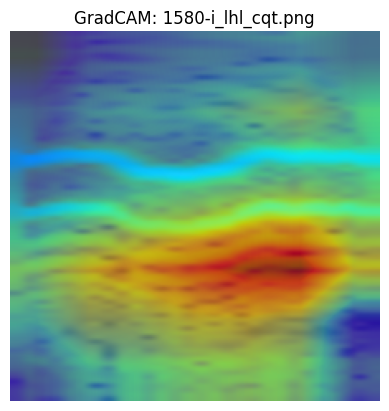

In [24]:
# ‚úÖ GradCAM ÂèØËß£ÈáäÊÄßÂàÜÊûê - Áî®‰∫é CausalSpectroNetÔºàConstantQOnly Ê®°ÂûãÔºâ
# ‰Ω†ÈúÄË¶ÅÁ°Æ‰øù `spectro_ablation_experiments.py` ‰∏é `.pth` Ê®°ÂûãÂú®ÂΩìÂâçÁõÆÂΩï

# ----------------------------
# Cell 1: ÂØºÂÖ•Ê®°Âùó‰∏éÊ®°ÂûãÁªìÊûÑ
# ----------------------------
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import os

from spectro_ablation_experiments import CausalSpectroNet

# ----------------------------
# Cell 2: ÂÆö‰πâ GradCAM Á±ª
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if isinstance(output, tuple):
            output = output[0]  # ÂÖºÂÆπËøîÂõû (logits, att) ÁöÑÊÉÖÂÜµ
        if class_idx is None:
            class_idx = output.argmax().item()
        loss = output[0, class_idx]
        self.model.zero_grad()
        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = F.relu((weights * self.activations).sum(dim=1, keepdim=True))
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        return cam.squeeze().cpu().numpy()

# ----------------------------
# Cell 3: Âä†ËΩΩÊ®°Âûã & ËÆæÁΩÆÁõÆÊ†áÂ±Ç
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "saved_models/ConstantQOnly_seed0.pth"
model = CausalSpectroNet().to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

# GradCAM ÁõÆÊ†áÂ±Ç‰∏∫ÊúÄÂêé‰∏ÄÁªÑÂç∑ÁßØÊ®°Âùó
target_layer = model.features[7]  # ÊàñËÄÖ dict([*model.features.named_modules()])["7"]
cam_generator = GradCAM(model, target_layer)

# ----------------------------
# Cell 4: ÂõæÂÉèÈ¢ÑÂ§ÑÁêÜÂáΩÊï∞‰∏é GradCAM ÂèØËßÜÂåñ
# ----------------------------
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def visualize_gradcam(img_path):
    img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(DEVICE)
    cam = cam_generator.generate(input_tensor)
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    plt.imshow(img.resize((224, 224)))
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title(f"GradCAM: {os.path.basename(img_path)}")
    plt.show()

# ----------------------------
# Cell 5: ÊµãËØï‰∏ÄÂº†ÂõæÂÉèË∑ØÂæÑ
# ----------------------------
img_path = "/Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_PD_Output/1580-i_lhl_cqt.png" # ÊõøÊç¢‰∏∫‰Ω†Ëá™Â∑±ÁöÑË∑ØÂæÑ
visualize_gradcam(img_path)

In [24]:
# ‚úÖ GradCAM ÂèØËß£ÈáäÊÄßÂàÜÊûê - Áî®‰∫é CausalSpectroNetÔºàConstantQOnly Ê®°ÂûãÔºâ
# ‰Ω†ÈúÄË¶ÅÁ°Æ‰øù `spectro_ablation_experiments.py` ‰∏é `.pth` Ê®°ÂûãÂú®ÂΩìÂâçÁõÆÂΩï

# ----------------------------
# Cell 1: ÂØºÂÖ•Ê®°Âùó‰∏éÊ®°ÂûãÁªìÊûÑ
# ----------------------------
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import os
import glob
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.cluster import KMeans

from spectro_ablation_experiments import CausalSpectroNet

# ----------------------------
# Cell 2: ÂÆö‰πâ GradCAM Á±ª
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if isinstance(output, tuple):
            output = output[0]
        if class_idx is None:
            class_idx = output.argmax().item()
        loss = output[0, class_idx]
        self.model.zero_grad()
        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = F.relu((weights * self.activations).sum(dim=1, keepdim=True))
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        return cam.squeeze().cpu().numpy()

# ----------------------------
# Cell 3: Âä†ËΩΩÊ®°Âûã & ËÆæÁΩÆÁõÆÊ†áÂ±Ç
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "saved_models/ConstantQOnly_seed0.pth"
model = CausalSpectroNet().to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

target_layer = model.features[7]
cam_generator = GradCAM(model, target_layer)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ----------------------------
# Cell 4: ÊâπÈáèÊèêÂèñ Top-K Â∑ÆÂºÇÂõæÂÉèË∑ØÂæÑ
# ----------------------------
topk_image_paths = sorted(
    glob.glob("/Users/beibeiliu/Downloads/4.20/Parkinson/Voice/**/*_Output/*_cqt.png", recursive=True)
)[:5]

print(f"üü¢ Found {len(topk_image_paths)} images:")
for i, p in enumerate(topk_image_paths):
    print(f"{i+1}. {p}")

# ----------------------------
# Cell 5: Token ÁÉ≠ÂäõÂõæÂáΩÊï∞
# ----------------------------
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model_wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").eval()

def extract_token_heatmap(wav_path, n_clusters=50):
    import torchaudio
    wav, sr = torchaudio.load(wav_path)
    if sr != 16000:
        wav = torchaudio.transforms.Resample(sr, 16000)(wav)
    inputs = processor(wav.squeeze(), return_tensors="pt", sampling_rate=16000)
    with torch.no_grad():
        out = model_wav2vec(**inputs).last_hidden_state.squeeze(0).numpy()
    km = KMeans(n_clusters=n_clusters, random_state=0).fit(out)
    return km.labels_

# ----------------------------
# Cell 6: GradCAM + Token Overlay ÂèØËßÜÂåñ
# ----------------------------
def overlay_gradcam_and_token(img_path):
    img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(DEVICE)
    cam = cam_generator.generate(input_tensor)
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    # Êé®Êñ≠Áõ∏Â∫î .wav Ë∑ØÂæÑ (IDxx_xx_chunkXX ÂØπÂ∫î IDxx_xx.wav)
    basename_prefix = os.path.basename(img_path).split("_chunk")[0]  # e.g. ID02_pd_2_0_0

    voice_root = "Voice"
    all_wav_dirs = [d for d in os.listdir(voice_root)
                    if os.path.isdir(os.path.join(voice_root, d))
                    and not d.endswith("Output")
                    and not d.endswith("Renamed_Files_Output")]

    candidates = []
    for folder in all_wav_dirs:
        candidate_path = os.path.join(voice_root, folder)
        matches = glob.glob(os.path.join(candidate_path, f"{basename_prefix}*.wav"))
        if matches:
            candidates.extend(matches)

    if not candidates:
        print(f"[WARN] Cannot find .wav for {img_path}")
        token_seq = None
    else:
        token_seq = extract_token_heatmap(candidates[0])

    # ÂèØËßÜÂåñ
    fig, axs = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={'height_ratios': [3, 1]})
    axs[0].imshow(img.resize((224, 224)))
    axs[0].imshow(cam, cmap='jet', alpha=0.5)
    axs[0].set_title("GradCAM Overlay")
    axs[0].axis('off')

    if token_seq is not None:
        axs[1].imshow(token_seq[np.newaxis, :], aspect='auto', cmap='tab20')
        axs[1].set_title("Token Heatmap")
        axs[1].set_yticks([])

    output_dir = "figures/gradcam_token_overlay"
    os.makedirs(output_dir, exist_ok=True)
    save_name = os.path.basename(img_path).replace(".png", "_overlay.png")
    plt.savefig(os.path.join(output_dir, save_name), dpi=300)
    plt.show()
    plt.close()


üü¢ Found 5 images:
1. /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/China_HC_Output/Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô 14_chunk0_cqt.png
2. /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/China_HC_Output/Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô 14_chunk6_cqt.png
3. /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/China_HC_Output/Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô 14_cqt.png
4. /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/China_HC_Output/Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô 2_chunk0_cqt.png
5. /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/China_HC_Output/Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô 2_chunk6_cqt.png


/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


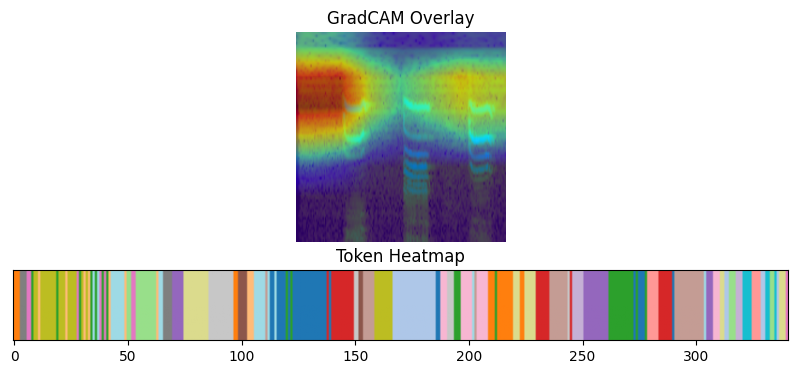

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


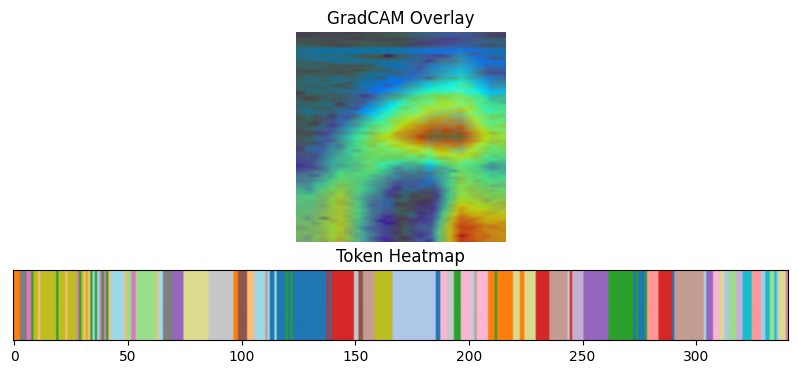

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


[WARN] Cannot find .wav for /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/China_HC_Output/Êª®Ê±üÊ∞¥Â≤∏Á§æÂå∫Âç´ÁîüÊúçÂä°Á´ô 14_cqt.png


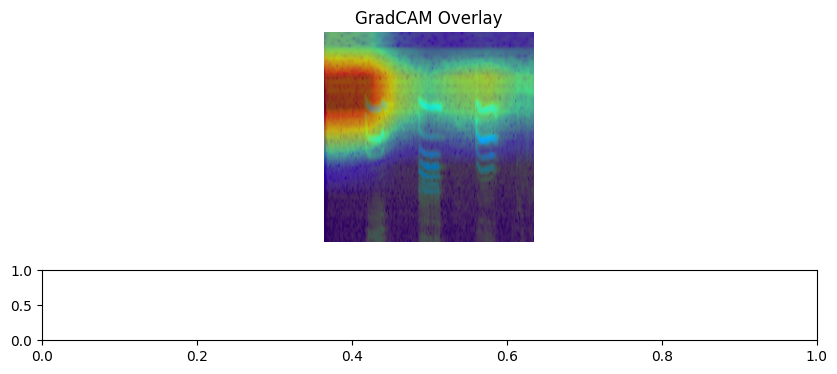

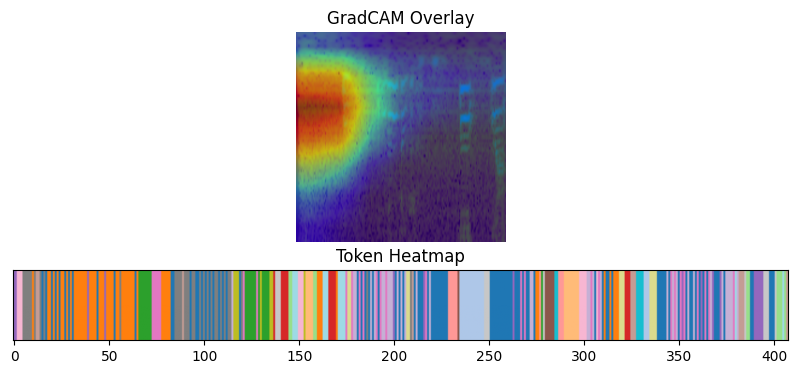

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


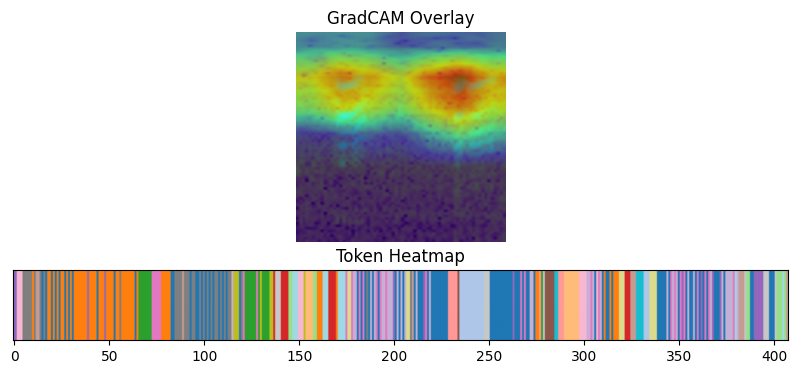

In [25]:
for path in topk_image_paths:
    overlay_gradcam_and_token(path)


[WARN] HC folder not found for: German_PD_Output

[üî•] Final Top-7 CQT Differences (dataset-matched):
#1: 111.19
  HC: Voice/KCL_Spontaneous_HC_Output/ID05_hc_0_0_0_trimmed_chunk42_cqt.png
  PD: Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_chunk60_cqt.png

#2: 110.21
  HC: Voice/KCL_Spontaneous_HC_Output/ID05_hc_0_0_0_trimmed_chunk42_cqt.png
  PD: Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_chunk24_cqt.png

#3: 109.81
  HC: Voice/KCL_Spontaneous_HC_Output/ID05_hc_0_0_0_trimmed_chunk42_cqt.png
  PD: Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_cqt.png

#4: 108.34
  HC: Voice/KCL_Spontaneous_HC_Output/ID05_hc_0_0_0_trimmed_chunk42_cqt.png
  PD: Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_chunk36_cqt.png

#5: 108.23
  HC: Voice/KCL_Spontaneous_HC_Output/ID23_hc_0_0_0_trimmed_chunk6_cqt.png
  PD: Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_chunk60_cqt.png

#6: 108.01
  HC: Voice/KCL_Spontaneous_HC_Output/ID12_hc_0_0_0_trimmed_chunk12_cqt.png
  PD: Voice/KCL_Spontaneous_PD_Output/

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


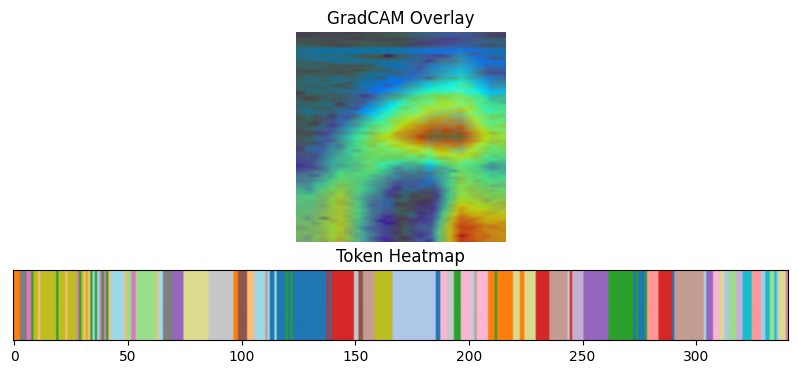

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


[WARN] Cannot find .wav for Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_cqt.png


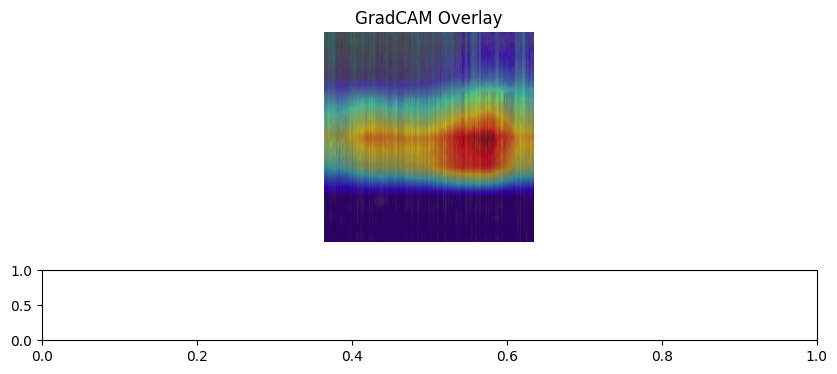

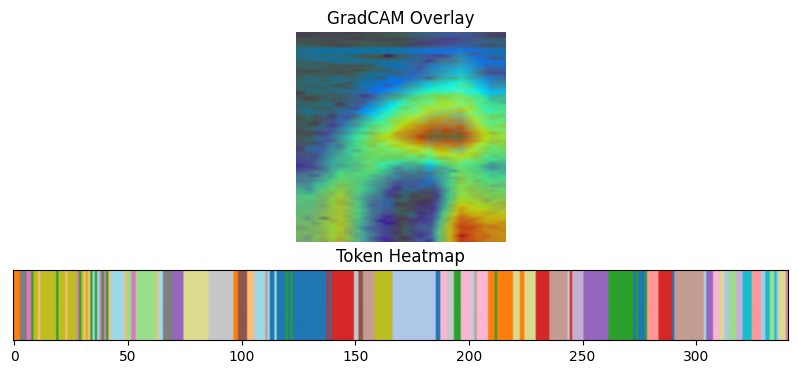

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


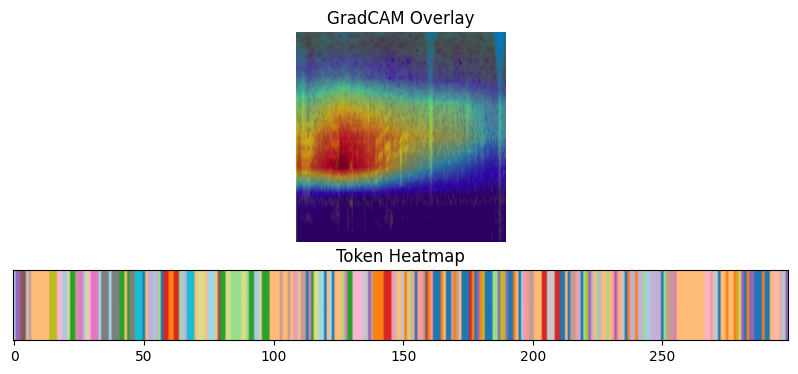

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


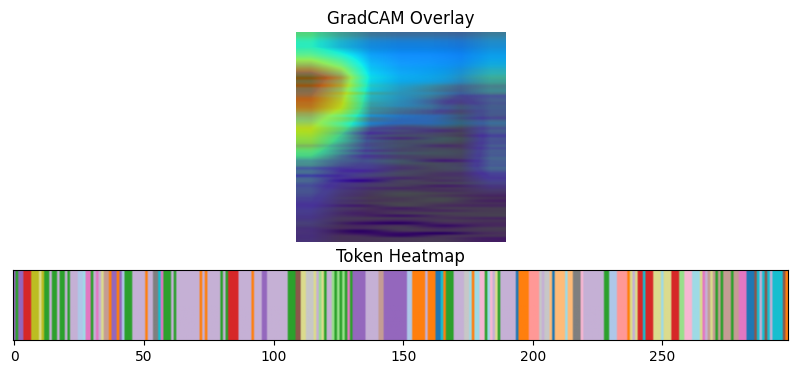

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


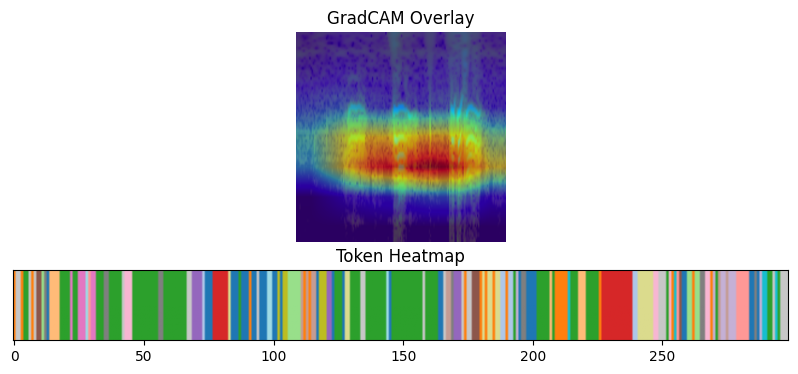

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


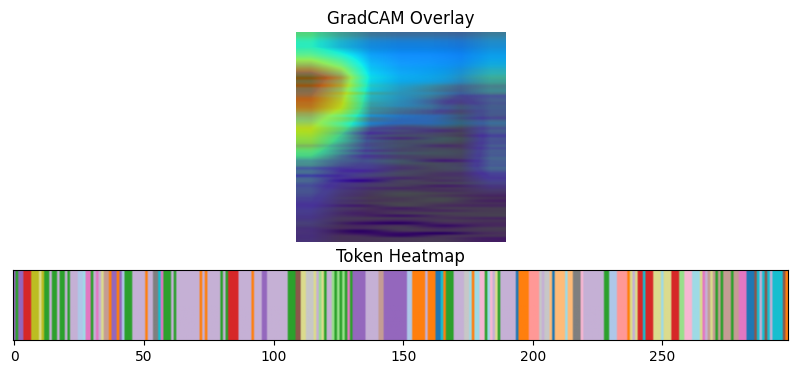

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


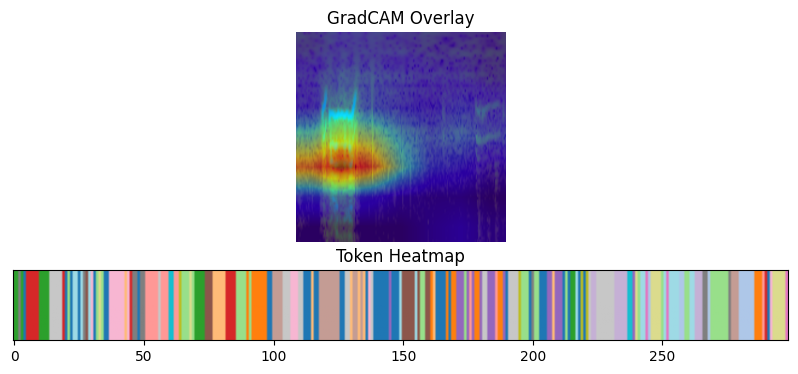

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


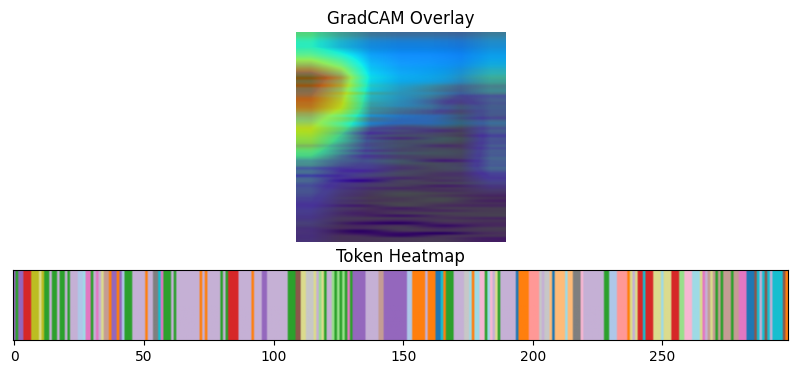

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


[WARN] Cannot find .wav for Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_cqt.png


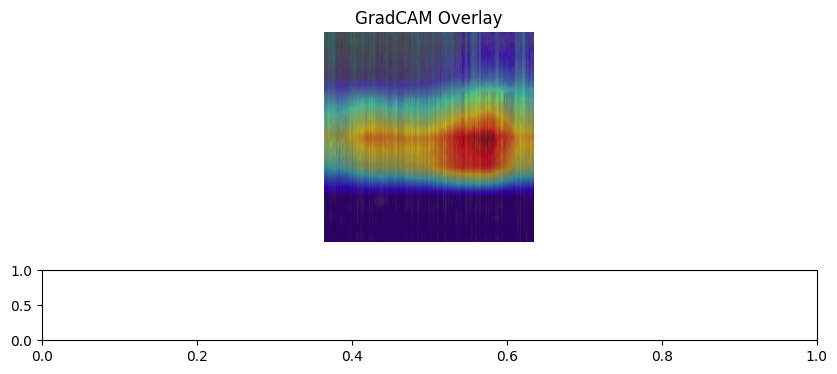

In [29]:
# ‚úÖ GradCAM ÂèØËß£ÈáäÊÄßÂàÜÊûê - Áî®‰∫é CausalSpectroNetÔºàConstantQOnly Ê®°ÂûãÔºâ
# ‰Ω†ÈúÄË¶ÅÁ°Æ‰øù `spectro_ablation_experiments.py` ‰∏é `.pth` Ê®°ÂûãÂú®ÂΩìÂâçÁõÆÂΩï

# ----------------------------
# Cell 1: ÂØºÂÖ•Ê®°Âùó‰∏éÊ®°ÂûãÁªìÊûÑ
# ----------------------------
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import os
import glob
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.cluster import KMeans
from spectro_ablation_experiments import CausalSpectroNet

# ----------------------------
# Cell 2: ÂÆö‰πâ GradCAM Á±ª
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if isinstance(output, tuple):
            output = output[0]
        if class_idx is None:
            class_idx = output.argmax().item()
        loss = output[0, class_idx]
        self.model.zero_grad()
        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = F.relu((weights * self.activations).sum(dim=1, keepdim=True))
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        return cam.squeeze().cpu().numpy()

# ----------------------------
# Cell 3: Âä†ËΩΩÊ®°Âûã & ËÆæÁΩÆÁõÆÊ†áÂ±Ç
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "saved_models/ConstantQOnly_seed0.pth"
model = CausalSpectroNet().to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

target_layer = model.features[7]
cam_generator = GradCAM(model, target_layer)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ----------------------------
# Cell 4: ËÆ°ÁÆó Top-K Âå∫ÂàÜÂ∑ÆÂºÇÊúÄÂ§ßÁöÑ HC vs PD ÂõæÂÉèÂØπ
# ----------------------------
def compute_image_difference(img1_path, img2_path):
    img1 = np.array(Image.open(img1_path).resize((224, 224))).astype(np.float32) / 255.0
    img2 = np.array(Image.open(img2_path).resize((224, 224))).astype(np.float32) / 255.0
    return np.linalg.norm(img1.flatten() - img2.flatten())

def find_topk_diff_pairs(root="Voice", topk=5):
    output_dirs = [d for d in os.listdir(root) if d.endswith("Output")]
    pd_dirs = [d for d in output_dirs if "_PD_" in d]
    topk_result_all = []

    for pd_dir in pd_dirs:
        pd_path = os.path.join(root, pd_dir)
        dataset_prefix = pd_dir.replace("_PD_Output", "")
        hc_dir = f"{dataset_prefix}_HC_Output"
        hc_path = os.path.join(root, hc_dir)

        if not os.path.exists(hc_path):
            print(f"[WARN] HC folder not found for: {pd_dir}")
            continue

        pd_images = sorted(glob.glob(os.path.join(pd_path, "*_cqt.png")))
        hc_images = sorted(glob.glob(os.path.join(hc_path, "*_cqt.png")))

        local_diffs = []
        for p in pd_images:
            for h in hc_images:
                try:
                    diff = compute_image_difference(h, p)
                    local_diffs.append((diff, h, p))
                except:
                    continue

        local_diffs = sorted(local_diffs, reverse=True)[:topk]
        topk_result_all.extend(local_diffs)

    # ÂÖ®Â±Ä Top-K
    topk_result_all = sorted(topk_result_all, reverse=True)[:topk]

    with open("topk_cqt_pairs_dataset_matched.txt", "w") as f:
        for d, h, p in topk_result_all:
            f.write(f"{h}|{p}\n")

    print(f"\n[üî•] Final Top-{topk} CQT Differences (dataset-matched):")
    for i, (d, h, p) in enumerate(topk_result_all):
        print(f"#{i+1}: {d:.2f}\n  HC: {h}\n  PD: {p}\n")

find_topk_diff_pairs(topk=7)

# ----------------------------
# Cell 5: ‰ªé txt ËØªÂèñ Top-K ÂõæË∑Ø
# ----------------------------
topk_image_paths = []
with open("topk_cqt_pairs.txt", "r") as f:
    for line in f:
        hc_path, pd_path = line.strip().split("|")
        topk_image_paths.extend([hc_path, pd_path])

# ----------------------------
# Cell 6: Token ÁÉ≠ÂäõÂõæÂáΩÊï∞
# ----------------------------
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model_wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").eval()

def extract_token_heatmap(wav_path, n_clusters=50):
    import torchaudio
    wav, sr = torchaudio.load(wav_path)
    if sr != 16000:
        wav = torchaudio.transforms.Resample(sr, 16000)(wav)
    inputs = processor(wav.squeeze(), return_tensors="pt", sampling_rate=16000)
    with torch.no_grad():
        out = model_wav2vec(**inputs).last_hidden_state.squeeze(0).numpy()
    km = KMeans(n_clusters=n_clusters, random_state=0).fit(out)
    return km.labels_

# ----------------------------
# Cell 7: GradCAM + Token Overlay ÂèØËßÜÂåñ
# ----------------------------
def overlay_gradcam_and_token(img_path):
    img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(DEVICE)
    cam = cam_generator.generate(input_tensor)
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    # Êé®Êñ≠ .wav Ë∑ØÂæÑ
    basename_prefix = os.path.basename(img_path).split("_chunk")[0]
    voice_root = "Voice"
    all_wav_dirs = [d for d in os.listdir(voice_root)
                    if os.path.isdir(os.path.join(voice_root, d))
                    and not d.endswith("Output")
                    and not d.endswith("Renamed_Files_Output")]
    candidates = []
    for folder in all_wav_dirs:
        matches = glob.glob(os.path.join(voice_root, folder, f"{basename_prefix}*.wav"))
        if matches:
            candidates.extend(matches)

    if not candidates:
        print(f"[WARN] Cannot find .wav for {img_path}")
        token_seq = None
    else:
        token_seq = extract_token_heatmap(candidates[0])

    fig, axs = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={'height_ratios': [3, 1]})
    axs[0].imshow(img.resize((224, 224)))
    axs[0].imshow(cam, cmap='jet', alpha=0.5)
    axs[0].set_title("GradCAM Overlay")
    axs[0].axis('off')

    if token_seq is not None:
        axs[1].imshow(token_seq[np.newaxis, :], aspect='auto', cmap='tab20')
        axs[1].set_title("Token Heatmap")
        axs[1].set_yticks([])

    output_dir = "figures/gradcam_token_overlay"
    os.makedirs(output_dir, exist_ok=True)
    save_name = os.path.basename(img_path).replace(".png", "_overlay.png")
    plt.savefig(os.path.join(output_dir, save_name), dpi=300)
    plt.show()
    plt.close()

# ----------------------------
# Cell 8: Ê∑ªÂä†ÊâßË°å
# ----------------------------
for path in topk_image_paths:
    overlay_gradcam_and_token(path)


üéØ Top-10 KL Divergence Tokens (Symmetric):
Token 60: KL=0.00045, HC=0.0104, PD=0.0127
Token 3: KL=0.00036, HC=0.0193, PD=0.0221
Token 58: KL=0.00032, HC=0.0109, PD=0.0128
Token 51: KL=0.00028, HC=0.0121, PD=0.0140
Token 62: KL=0.00019, HC=0.0104, PD=0.0119
Token 9: KL=0.00013, HC=0.0188, PD=0.0173
Token 40: KL=0.00013, HC=0.0137, PD=0.0151
Token 13: KL=0.00012, HC=0.0191, PD=0.0176
Token 57: KL=0.00012, HC=0.0113, PD=0.0125
Token 61: KL=0.00012, HC=0.0106, PD=0.0118


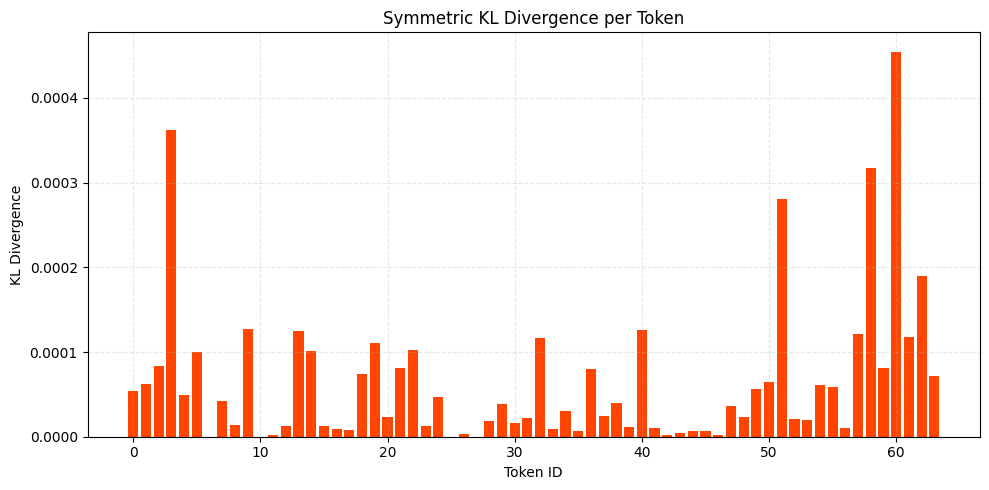

Jensen-Shannon Divergence (HC vs PD): 0.000753


In [32]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon

# ---------------------------
# 1. ËØªÂèñÂπ∂Ëß£Êûê CSV ‰∏≠ÁöÑ token Â∫èÂàó
# ---------------------------
csv_path = "audio_token_results.csv"  # ‚Üê ËØ∑Á°Æ‰øùË∑ØÂæÑÊ≠£Á°Æ
n_clusters = 64  # ‚Üê ‰∏éÂéüÂÖàÁöÑ KMeans ËÅöÁ±ªÊï∞‰∏ÄËá¥

df = pd.read_csv(csv_path, encoding="utf-8-sig")

# Â∞ÜÂ≠óÁ¨¶‰∏≤Á±ªÂûãÁöÑ tokens ËΩ¨Êç¢‰∏∫ list[int]
def parse_tokens(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

df["tokens_parsed"] = df["tokens"].apply(parse_tokens)

# ---------------------------
# 2. ÁªüËÆ° HC / PD ÂÖ®Â±ÄÈ¢ëÁéáÂàÜÂ∏É
# ---------------------------
counts_HC = np.zeros(n_clusters, dtype=int)
counts_PD = np.zeros(n_clusters, dtype=int)

for _, row in df.iterrows():
    tokens = row["tokens_parsed"]
    label = str(row["label"]).strip()
    count = np.bincount(tokens, minlength=n_clusters)
    if label in ["0", "HC"]:
        counts_HC += count
    elif label in ["1", "PD"]:
        counts_PD += count

total_HC = counts_HC.sum()
total_PD = counts_PD.sum()

# ÈÅøÂÖçÈô§‰ª• 0
hc_freq = counts_HC / total_HC if total_HC > 0 else np.zeros_like(counts_HC)
pd_freq = counts_PD / total_PD if total_PD > 0 else np.zeros_like(counts_PD)

# Âä†‰∏Ä‰∏™ÂæÆÂ∞èÂπ≥ÊªëÂÄºÈò≤Ê≠¢ log(0)
eps = 1e-10
hc_freq += eps
pd_freq += eps
hc_freq /= hc_freq.sum()
pd_freq /= pd_freq.sum()

# ---------------------------
# 3. ËÆ°ÁÆó KL Êï£Â∫¶Ôºà‰∏§‰∏™ÊñπÂêëÔºâÂíå JS Êï£Â∫¶
# ---------------------------
kl_HC_PD = rel_entr(hc_freq, pd_freq)  # D_KL(P‚ÄñQ)
kl_PD_HC = rel_entr(pd_freq, hc_freq)  # D_KL(Q‚ÄñP)
kl_sym = kl_HC_PD + kl_PD_HC           # Symmetric KL
js_div = jensenshannon(hc_freq, pd_freq, base=2) ** 2  # JS divergence ÊòØË∑ùÁ¶ªÁöÑÂπ≥Êñπ

# ËÆ∞ÂΩïÁªìÊûú
kl_values = kl_sym
js_value = js_div

# ---------------------------
# 4. ËæìÂá∫ top-K KL Êï£Â∫¶ÊúÄÂ§ßÁöÑ token
# ---------------------------
top_k = 10
kl_token_scores = [(i, float(kl_sym[i]), hc_freq[i], pd_freq[i]) for i in range(n_clusters)]
kl_token_scores.sort(key=lambda x: x[1], reverse=True)

print(f"üéØ Top-{top_k} KL Divergence Tokens (Symmetric):")
for tid, score, h, p in kl_token_scores[:top_k]:
    print(f"Token {tid}: KL={score:.5f}, HC={h:.4f}, PD={p:.4f}")

# ---------------------------
# 5. ÂèØËßÜÂåñÔºöKL Êï£Â∫¶ÁÉ≠Âõæ
# ---------------------------
plt.figure(figsize=(10, 5))
plt.bar(range(n_clusters), kl_sym, color='orangered')
plt.title("Symmetric KL Divergence per Token")
plt.xlabel("Token ID")
plt.ylabel("KL Divergence")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------
# 6. ÂèØËßÜÂåñÔºöJS Êï£Â∫¶ÂÄºÔºàÂè™Êúâ‰∏Ä‰∏™ÂÄºÔºâ
# ---------------------------
print(f"Jensen-Shannon Divergence (HC vs PD): {js_value:.6f}")
